In [60]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

In [61]:
from datasets import load_dataset
from transformers import AutoTokenizer, \
                          AutoModelForSequenceClassification, \
                          TrainingArguments, \
                          Trainer, \
                          BertConfig, \
                          AutoConfig, \
                          set_seed
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    torch.cuda.empty_cache()

set_seed(42)

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 1.3 GB
Cached:    6.5 GB


# Data loading

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


In [65]:
df_dev = load_dataset("csv", data_files="dataset/subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

# Data partioning

In [66]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [67]:
df_train = train_val["train"]
df_val = train_val["test"]

In [68]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [69]:
nome = 'bert-base-italian-xxl-cased'
model_name = 'dbmdz/bert-base-italian-xxl-cased'

In [70]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [71]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [72]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

In [73]:
tokenized_train

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1288
})

In [74]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [75]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [76]:
config = AutoConfig.from_pretrained(model_name)

In [77]:
# config.dropout = 0.001

In [78]:
print(config)

BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-xxl-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32102
}



In [79]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [80]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name)

In [81]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [82]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
%%time
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.533800,0.446146,0.809767
2,0.314300,0.743946,0.772677
3,0.103600,1.026068,0.802427
4,0.017900,1.263445,0.802857
5,0.008900,1.378952,0.820647
6,0.014600,1.428553,0.802520
7,0.019700,1.313981,0.811594
8,0.013600,1.404516,0.811294
9,0.005200,1.319684,0.815196
10,0.004400,1.326463,0.818803


CPU times: user 34min 55s, sys: 37.8 s, total: 35min 33s
Wall time: 42min 9s


TrainOutput(global_step=2415, training_loss=0.07007073721777085, metrics={'train_runtime': 2526.6382, 'train_samples_per_second': 7.647, 'train_steps_per_second': 0.956, 'total_flos': 5083305589555200.0, 'train_loss': 0.07007073721777085, 'epoch': 15.0})

# Evaluation

In [84]:
log_history = trainer.state.log_history

In [85]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

<ipython-input-85-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-85-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-85-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-85-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

,Epoch,Loss,Dataset
0,1,0.533800,Training
1,1,0.446146,Validation
2,2,0.314300,Training
3,2,0.743946,Validation
4,3,0.103600,Training
5,3,1.026068,Validation
6,4,0.017900,Training
7,4,1.263445,Validation
8,5,0.008900,Training
9,5,1.378952,Validation


In [86]:
from IPython.display import HTML

df.to_html(f'loss_{nome}.html')

display(HTML(f'loss_{nome}.html'))

,Epoch,Loss,Dataset
0,1,0.533800,Training
1,1,0.446146,Validation
2,2,0.314300,Training
3,2,0.743946,Validation
4,3,0.103600,Training
5,3,1.026068,Validation
6,4,0.017900,Training
7,4,1.263445,Validation
8,5,0.008900,Training
9,5,1.378952,Validation


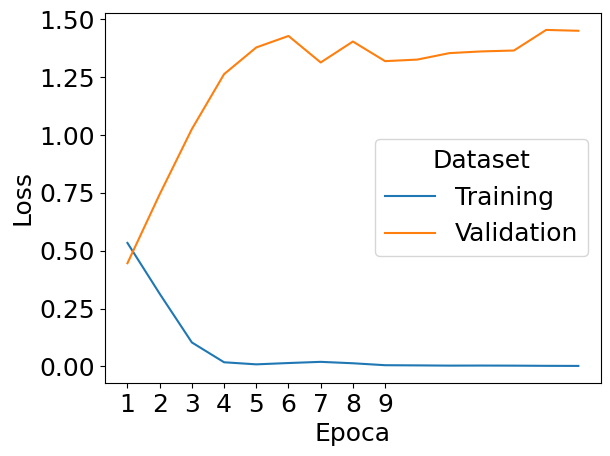

In [87]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 10))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [88]:
output_predictions = trainer.predict(tokenized_val)

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [90]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       279
           1       0.82      0.82      0.82       273

    accuracy                           0.82       552
   macro avg       0.82      0.82      0.82       552
weighted avg       0.82      0.82      0.82       552



In [91]:
with open(f"class_report_{nome}.html", "w") as file:
    file.write(report)

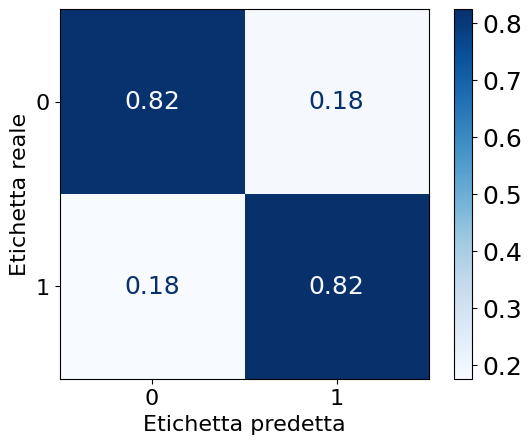

In [92]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()